# <strong>Statistics 2 (Chapter 11)
<strong>주성분 분석(PCA)</strong>은 <strong>상관관계를 갖는 관측값</strong> 변수들을 <strong>'직교변환'</strong>을 사용하여 선형 상관관계를 갖지않는 주성분의 집합으로 변환

<br>
## <strong>3 주성분 분석 (PCA)
Principal Component Analysis
1. <strong>주성분</strong> : 직교변환을 사용하여 상관관계를 갖는 관측값 변수들의 집합
1. <strong>가장 큰 분산의 값</strong>을 찾은 뒤, 이와 <strong>직교 제약조건내 큰 분산값</strong>을 차례로 찾는다

### <strong>01 KOSPI 지수와 구성종목 수집
1. get_data_yahoo 에서 자료 수집
1. 컬럼명 한글로 변환
1. Nan 등 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import get_data_yahoo
symbols = ['^KS11','005930.KS','000660.KS','005380.KS','005490.KS','015760.KS','051910.KS','035420.KS',
           '012330.KS','055550.KS','032830.KS','105560.KS','017670.KS','034730.KS','028260.KS',
           '096770.KS','090430.KS','051900.KS','003550.KS','066570.KS','011170.KS','000270.KS',
           '068270.KQ','010950.KS','086790.KS','006400.KS','251270.KS','000810.KS','018260.KS'] 
# %%time
# data = pd.DataFrame()
# for sym in symbols:
#     i = 0
#     for i in range(3):
#         try:
#             data[sym] = get_data_yahoo(sym, '2015-01-01')['Close']; break
#         except: print(sym, i, 'error')
# data.to_csv('./data/krx.csv')
data = pd.read_csv('./data/krx.csv')   # 모든 데이터를 column으로 불러오기 (index는 자동생성)
data = data.set_index('Date')          # index를 'Date' 컬럼으로 설정
data.index = pd.to_datetime(data.index) # index를 datetime64 type 변환

# 데이터 전처리
krx = pd.DataFrame(data.pop('^KS11'))        # Kospi Index 만 추출
df  = pd.read_csv('./Stock/Sql/Gsheet.csv')  # Code 대신 기업이름 지정
codes, names = {}, {}
for i, code in enumerate(df.Code):
    codes[df.Code[i]] = df.Name[i]
    names[df.Name[i]] = df.Code[i]
data.columns = ['코스피'] + [codes[code] for code in data.columns[1:]]

err = []
for i, datum in enumerate(data.iloc[1,:]):  # Nan 데이터 전처리 (최초값이 없는 필드를 삭제)
    if datum > 0: pass
    else:         err.append(data.columns[i])
data.pop(err[0])
data = data.fillna(method='ffill')          # 중간에 Nan이 존재시, 직전의 가격을 덧붙인다
data[data.columns[:10]].head(3)

,코스피,SK하이닉스,현대자동차,포스코,한국전력공사,LG화학,NAVER,현대모비스,신한지주,삼성생명
Date,,,,,,,,,,
2015-01-02,1330000.0,47750.0,169000.0,283500.0,42700.0,180000.0,731000.0,239500.0,44500.0,115000.0
2015-01-05,1333000.0,47650.0,168000.0,279000.0,42000.0,174500.0,749000.0,238000.0,44200.0,117000.0
2015-01-06,1295000.0,47500.0,164500.0,275000.0,41850.0,166000.0,743000.0,229000.0,43550.0,115500.0


### <strong>02 주성분 분석 적용하기 (Applying PCA)
1. 모든 종목과의 상관분석을 수행하는 과정은 복잡하다
1. <strong>관련성이 높은종목 3~5를 추출</strong>하기 위한 주성분 분석을 실행한다

In [2]:
from sklearn.decomposition import KernelPCA
scale_function = lambda x: (x-x.mean()) / x.std()                 # 주식 종가 데이터를 정규화
pca = KernelPCA().fit(data.apply(scale_function))                 # 1) 주성분 갯수를 제한하기 않고 추출 cf) 실무는 '수익률'을 분석한다
print('주성분 분석(무제한) : {}개'.format(len(pca.lambdas_)))          # 주성분 추출결과 413개로 갯수가 아직도 많다
print('\n주성분 분석(상위10) : {}'.format(pca.lambdas_[:10].round())) # 2) 주성분 상위 10개 : 상관성이 급격하게 하락하여 10번째 뒤는 무의미

get_we = lambda x: x / x.sum()                                                   # 정규화 사용자 함수
print('\n(정규화) 상위 10개 데이터  : \n{}'.format(get_we(pca.lambdas_)[:10]))        # 상위 10개 데이터를 정규화 한다
print('\n(정규화) 상위 6개 주성분 총합 : \n{}'.format(get_we(pca.lambdas_)[:6].sum())) # 상위 6개의 주성분 총합 : 변동치의 91%를 설명가능

주성분 분석(무제한) : 415개

주성분 분석(상위10) : [10634.  3169.  2019.  1169.   820.   512.   297.   265.   245.   167.]

(정규화) 상위 10개 데이터  : 
[0.53077658 0.15818712 0.10080011 0.0583728  0.0409492  0.02554148
 0.01481927 0.01323051 0.01223096 0.00834969]

(정규화) 상위 6개 주성분 총합 : 
0.9146272861849827


### <strong>03 주성분 지수의 구성내용 살펴보기
Constructing a PCA Index

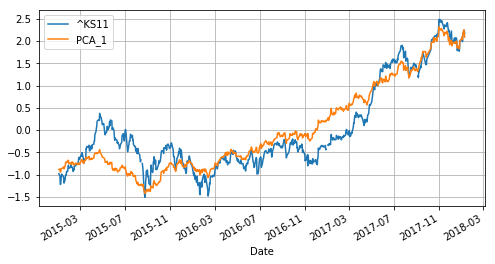

In [3]:
# 1.주성분을 1개로 정의한 경우 (Constructing a One PCA Index)
%matplotlib inline
import matplotlib.pyplot as plt

pca          = KernelPCA(n_components = 1).fit(data.apply(scale_function)) 
krx['PCA_1'] = pca.transform(data)
krx.apply(scale_function).plot(figsize=(8, 4)); plt.grid()

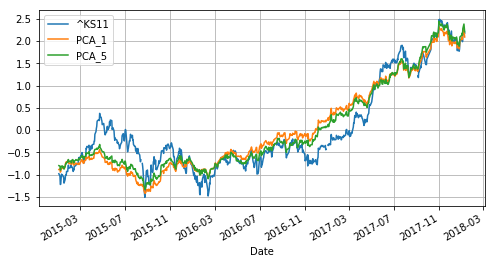

In [5]:
# 2.주성분을 5개로 정의한 경우 (Constructing Five PCA Index)
# 단일성분을 주성분 분석하는 경우, 가중평균을 계산해야 한다
pca = KernelPCA(n_components = 5).fit(data.apply(scale_function)) # PCA 알고리즘 적용
pca_components = pca.transform(-data)                              # 데이터 출력
weights        = get_we(pca.lambdas_)
krx['PCA_5']   = np.dot(pca_components, weights)
krx.apply(scale_function).plot(figsize=(8, 4)); plt.grid()

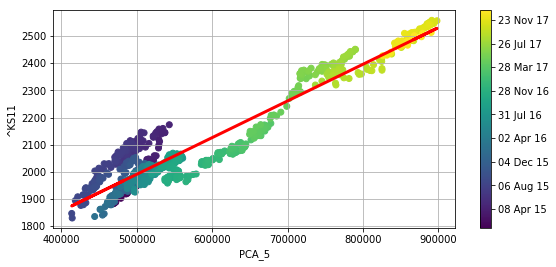

In [6]:
# 3.날짜정보를 추가한 Scatter Plot의 주성분 분석 (Datetime-Index)
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())  # 날짜를 timestamp 형식으로 변환
krx = krx.fillna(method='ffill')                            # (주의!) 중간에 Nan를 제거해야 선형회귀가 완성

plt.figure(figsize=(9, 4))
plt.scatter(krx['PCA_5'].values, krx['^KS11'].values, c = mpl_dates)
lin_reg = np.polyval(np.polyfit( krx['PCA_5'], 
                                 krx['^KS11'], 1),
                                 krx['PCA_5'])   # Kospi 지수과 주성분 분석 수익률의 선형회귀
plt.plot(krx['PCA_5'], lin_reg, 'r-', lw=3)      # Nan만 출력되어 그림이 그려지지 않는다
plt.grid(True); plt.xlabel('PCA_5'); plt.ylabel('^KS11')
plt.colorbar(ticks  = mpl.dates.DayLocator(interval = 120),
             format = mpl.dates.DateFormatter('%d %b %y'))   # 2016 전반에 급격한 변화가 발견

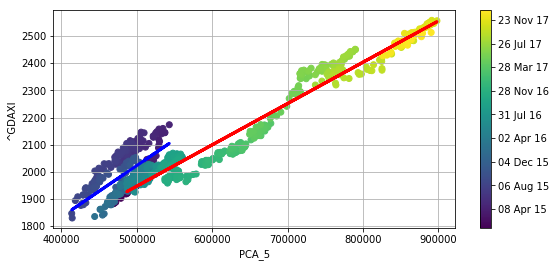

In [7]:
# 4. '2016-4-1'를 기준으로 전/후반 구간을 나눈다
cut_date = '2016-4-1'  
early_pca = krx[krx.index < cut_date]['PCA_5']   # 초기구간에 대한 회귀분석
early_reg = np.polyval(np.polyfit(early_pca,
                       krx['^KS11'][krx.index < cut_date], 1), early_pca)
late_pca  = krx[krx.index >= cut_date]['PCA_5']  # 후기구간에 대한 회귀분석
late_reg  = np.polyval(np.polyfit(late_pca,
                       krx['^KS11'][krx.index >= cut_date], 1), late_pca)

plt.figure(figsize=(9, 4))   # KRX 코스피와, 주성분 분석 수익률 전/후반 선형회귀
plt.scatter(krx['PCA_5'].values, krx['^KS11'].values, c = mpl_dates)
plt.plot(early_pca, early_reg, 'b', lw=3)   # 초기구간에 대한 회귀분석 시각화
plt.plot(late_pca,  late_reg, 'r-', lw=3)   # 후기구간에 대한 회귀분석 시각화
plt.grid(True); plt.xlabel('PCA_5'); plt.ylabel('^GDAXI')
plt.colorbar(ticks  = mpl.dates.DayLocator(interval=120),
             format = mpl.dates.DateFormatter('%d %b %y'))  # 2016 전반에 급격한 변화가 발견

<br>
## <strong>4 베이즈 회귀분석
Bayesian Regression
### <strong>01 베이즈 정리
$$ p(H|D) = \frac{p(H)p(D|H)}{p(D)} $$
1. $p(H)$ : 가설 H가 맞을 사전확률 Prior Probability
1. $p(D)$ : 특정한 자료 D가 나올 수 있는 모든 확률 한정상수 normalizing Constant
1. $p(D|H)$ : 가설 H하에 특정한 자료 D가 나올 확률 우도값 Likelihood
1. $p(H|D)$ : 특정한 자료 D가 나왔음을 확인한 상황에서 가설 H가 맞을 사후확률 Posterior Probability

예제) 상자 $B_1$ 에는 20/70(검정/붉은), 상자 $B_2$ 에는 40/50(검정/붉은) 이 있다

무작위로 두 상자 중 하나에서 검은공 하나를 꺼냈을떄 $H_1$ : $B_1$에서 나올확률, $H_2$ : $B_2$에서 나올확률의 확률값은?

풀이) 
- 공을 꺼내기 전의 가설확률 : $p(H_1)$ = 0.5
- 정규화 상수 : $p(D)$ = 0.5 X 0.2 + 0.5 X 0.4 = 0.3
- 우도 : $p(D|H)$ = 0.2
- 일 때 가설 $H_1$의확률 $p(H_1|D) = \frac{(0.5 X 0.2)}{(0.3)} = \frac{1}{3}$

### <strong>02 PyMC3 모듈을 활용한 베이즈 정리
가상의 자료를 확용한 베이즈 회귀분석
1. pip install Theano
1. pip install pymc3

다항식의 계산 : numpy.polyfit([4,7,5,2],x) => 4X^3 + 7X^2 + 5X + 2 

1차원 선형회귀 (weight : 2.0381, bias : 3.8057):


/home/markbaum/Python/django/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0,0.5,'y')

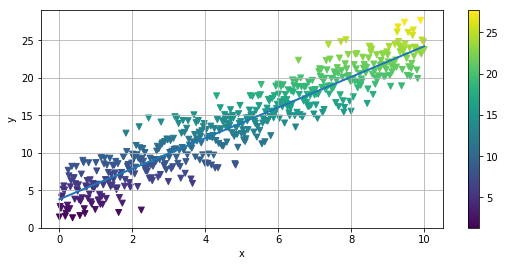

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np

# 1. 선형 데이터의 1차 회귀식 연산
x   = np.linspace(0, 10, 500)
y   = 4 + 2 * x + np.random.standard_normal(len(x)) * 2  # 일직선상 잡음이 있는 자료를 생성
reg = np.polyfit(x, y, 1)                                 # np.polyfit : x + y + 1 (1차 선형회귀식을 정의)
print('1차원 선형회귀 (weight : {:.4f}, bias : {:.4f}):'.format(reg[0], reg[1])) 

plt.figure(figsize=(9, 4))
plt.scatter(x, y, c = y, marker = 'v')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)  # 1차 선형 회귀식 적용 결과값
plt.colorbar(); plt.grid(True); plt.xlabel('x'); plt.ylabel('y')

logp = -1,087.2, ||grad|| = 44.318: 100%|██████████| 27/27 [00:00<00:00, 1983.44it/s]  
/home/markbaum/Python/django/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
/home/markbaum/Python/django/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))


{'alpha': 3.9127284043066006,
 'beta': 2.0086381109845943,
 'sigma': 1.961925153971609,
 'sigma_interval__': -1.4102633949147727}

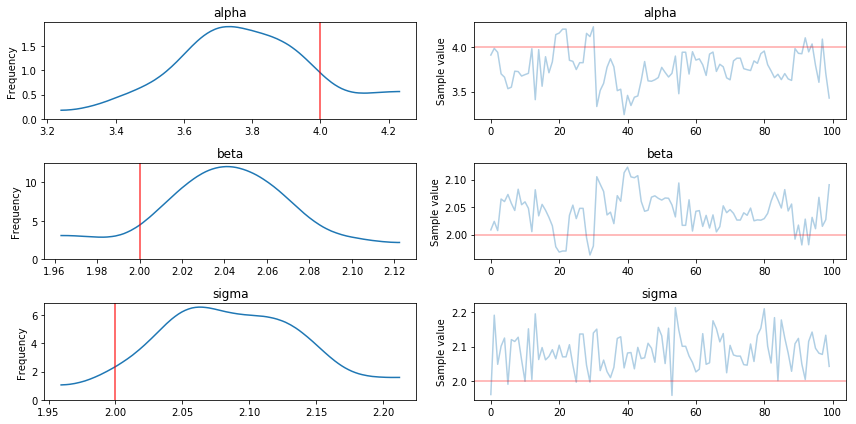

In [9]:
import pymc3 as pm                                                     # PyMC3는 with 구문으로 사용
with pm.Model() as model:
    alpha = pm.Normal('alpha',  mu=0,    sd=20)                        # 사전 확률 정의
    beta  = pm.Normal('beta' ,  mu=0,    sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    y_est = alpha + beta * x                                           # 선형 회귀선 정의
    likelihood = pm.Normal('y', mu = y_est, sd = sigma, observed = y)  # 우도값 측정
    start = pm.find_MAP()                                              # 추정과정
    step  = pm.NUTS(scaling = start)                                   # MCMC 샘플링 인스턴스를 생성
    trace = pm.sample(100, step, start = start, progressbar = False)   # NUTS 샘플링으로 100개 사후 샘플을 생성

# alpha, beta, sigma 모수에 대한 최종 사후분포와 샘플마다의 추정값을 출력
fig = pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2})
plt.figure(figsize=(8, 8))
trace[0]  # 첫번쨰 샘플에서 추정한 값 출력

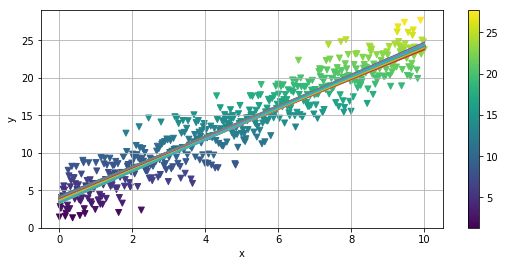

In [10]:
plt.figure(figsize=(9, 4))
plt.scatter(x, y, c=y, marker='v')                        # x, y 자료를 출력
plt.colorbar(); plt.grid(True); plt.xlabel('x'); plt.ylabel('y')
for i in range(len(trace)):         
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x) # 샘플자료와 베이즈 회귀분석을 통한 회귀선

### <strong>03 현실 자료에 적용
ETF 상품에 대한 베이지안 회귀식 반영

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2020 entries, 2009-12-31 to 2018-01-09
Data columns (total 2 columns):
GLD    2020 non-null float64
GDX    2020 non-null float64
dtypes: float64(2)
memory usage: 47.3 KB


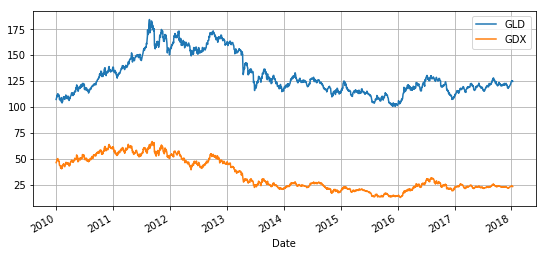

In [11]:
# 1. 데이터 불러오기
data    = pd.DataFrame()
symbols = ['GLD', 'GDX']
# for sym in symbols:
#     data[sym] = get_data_yahoo(sym)['Close']
# data.to_csv('./data/etf.csv')
data = pd.read_csv('./data/etf.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.plot(figsize=(9,4), grid=True)
data.info()

<ETF 상품의 절대 수익률 >
GLD    0.162333
GDX   -0.499892
dtype: float64

 <ETF 상품들의 상관관계> 
         GLD      GDX
GLD  1.00000  0.71597
GDX  0.71597  1.00000
 (결론) 강한 상관관계를 갖는다!!


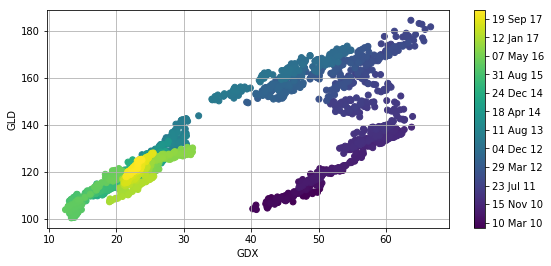

In [12]:
# 2. 2개의 상품에 대한 상관관계 분석
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())  # matplotlib에서 datetime포맷을 변경
print('<ETF 상품의 절대 수익률 >\n{}\n\n <ETF 상품들의 상관관계> \n{}\n (결론) 강한 상관관계를 갖는다!!'.format(
       data.iloc[-1] / data.iloc[0] - 1, # 두 ETF 상품의 절대 수익률 변화
       data.corr()))                     # 둘은 강한 양의 상관관계를 갖는다

plt.figure(figsize=(9, 4))               # GLD 와 GDX 가격을 날짜별 색변화로 점을 찍어서 표시한다
plt.scatter(data['GDX'].values, 
            data['GLD'].values,
            c = mpl_dates, marker = 'o')
plt.grid(True); plt.xlabel('GDX'); plt.ylabel('GLD')
plt.colorbar(ticks  = mpl.dates.DayLocator(interval=250),
             format = mpl.dates.DateFormatter('%d %b %y'))
# 단점 : 시간의 변화에 따른 변화를 고려하지 못한다 (최근과 과거의 자료를 동일하게 취급한다)
# 보완 : 시간의 변화에 따라 random walk하게 변화하는 확률을 대입하는 Pymc3모듈을 사용하면 된다

logp = -10,455, ||grad|| = 111.88: 100%|██████████| 21/21 [00:00<00:00, 1908.03it/s]  
/home/markbaum/Python/django/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
/home/markbaum/Python/django/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))
/home/markbaum/Python/django/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)


{'alpha': 100.57420192187448,
 'beta': 0.8903576710134026,
 'sigma': 13.484688025793307,
 'sigma_interval__': -0.9961768573448642}

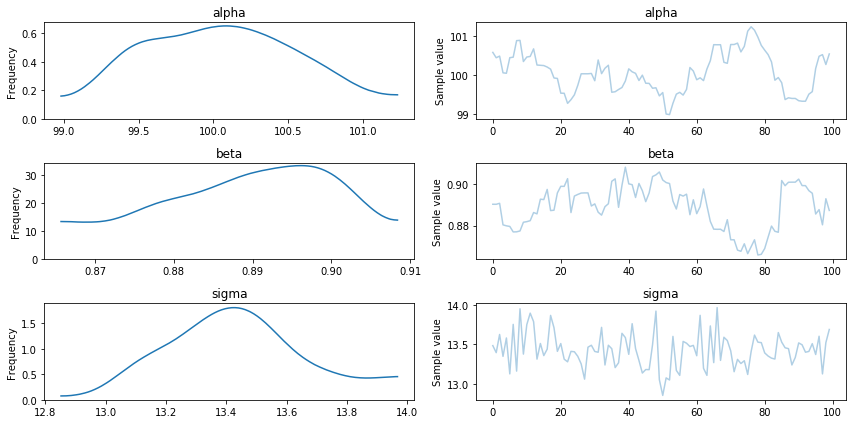

In [13]:
# 3. 시계열 Basis에 대한 bayes 회귀분석을 수행
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0,  sd=20)
    beta  = pm.Normal('beta',  mu=0,  sd=20)
    sigma = pm.Uniform('sigma',lower=0, upper=50)    
    y_est = alpha + beta * data['GDX'].values
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed=data['GLD'].values)
    start = pm.find_MAP()
    step  = pm.NUTS(scaling = start)  # MCMC 샘플링 인스턴스를 생성
    trace = pm.sample(100, step, start=start, progressbar=False)

# GLD 와 GDX 에 기반한 alpha, beta, sigma 모수의 trace plot
fig = pm.traceplot(trace)
plt.figure(figsize=(9, 8))
trace[0]

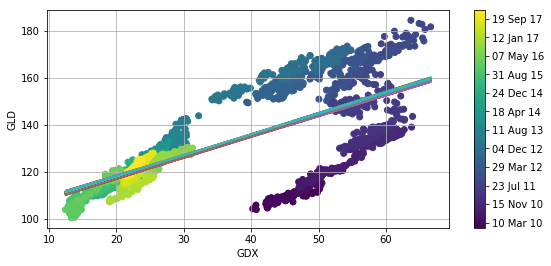

In [14]:
plt.figure(figsize=(9, 4))
plt.scatter(data['GDX'].values, data['GLD'].values, c=mpl_dates, marker='o')
plt.grid(True); plt.xlabel('GDX'); plt.ylabel('GLD')

for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i] * data['GDX'])
plt.colorbar(ticks  = mpl.dates.DayLocator(interval=250),
             format = mpl.dates.DateFormatter('%d %b %y'))
# 1차 선형 회귀선 분석 결과 : 모든 회귀선들이 가깝게 존재한다
# 시간에 따른 변화를 고려하지 못하는 단점이 있다

### <strong>04 Random Walk 모델을 활용
시간에 따른 변화를 분석하기 위해 자료의 <strong>분산값을 Log 공간으로 변환</strong>하여 사용한다

http://docs.pymc.io/notebooks/stochastic_volatility.html

In [15]:
# 책의 422페이지의 랜덤위크 모델의 코드가 저자자료엔 없다
# 현재도 작업 초기 부분에 아래와 같은 오류가 발생
# 이는 '베이지안'에 대한 파이썬 개별 코드를 익힌 뒤 새로 접근할 필요가 있다

In [16]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 1./ .02, testval = .1)
    sigma_beta  = pm.Exponential('sigma_beta',  1./ .02, testval = .1)

    sigma_alpha**-2

In [17]:
from pymc3.distributions.timeseries import GaussianRandomWalk
subsample_alpha = 101
subsample_beta = 101

with model_randomwalk:
#     alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape=int(len(data))/ subsample_alpha)
#     beta  = GaussianRandomWalk('beta',  sigma_beta**-2,  shape=int(len(data))/ subsample_beta)
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)